TD3 Implementation on Hopper-v4 environment as mentioned in the paper - Addressing Function Approximation Error in Actor-Critic Methods

Source-
Replay Buffer-https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
TD3-https://github.com/sfujim/TD3/blob/master/TD3.py

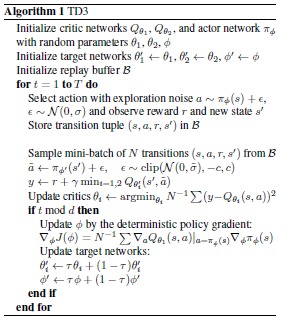

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

# Set compute device
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, action_limit):
        super(PolicyNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_size, 400)
        self.hidden2 = nn.Linear(400,300)
        self.output_layer = nn.Linear(300, output_size)
        self.action_limit = action_limit

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        return self.action_limit * torch.tanh(self.output_layer(x))

class ValueNetwork(nn.Module):
    def __init__(self, input_size, action_size):
        super(ValueNetwork, self).__init__()
        
        # First Q network
        self.fc1_1 = nn.Linear(input_size + action_size, 400)
        self.fc1_2 = nn.Linear(400, 300)
        self.q1_out = nn.Linear(300, 1)
        
        # Second Q network
        self.fc2_1 = nn.Linear(input_size + action_size, 400)
        self.fc2_2 = nn.Linear(400, 300)
        self.q2_out = nn.Linear(300, 1)

    def forward(self, state, action):
        combined = torch.cat([state, action], 1)
        
        # First Q network
        q1 = F.relu(self.fc1_1(combined))
        q1 = F.relu(self.fc1_2(q1))
        q1 = self.q1_out(q1)
        
        # Second Q network
        q2 = F.relu(self.fc2_1(combined))
        q2 = F.relu(self.fc2_2(q2))
        q2 = self.q2_out(q2)
        
        return q1, q2

    def first_q(self, state, action):
        combined = torch.cat([state, action], 1)
        q1 = F.relu(self.fc1_1(combined))
        q1 = F.relu(self.fc1_2(q1))
        return self.q1_out(q1)

class PrioritizedMemory:
    def __init__(self, capacity=1000000, priority_factor=0.7):
        self.capacity = int(capacity)
        self.priority_factor = priority_factor
        self.memory = deque(maxlen=self.capacity)
        self.priority_values = deque(maxlen=self.capacity)

    def store(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priority_values.append(float(priority) ** self.priority_factor)

    def get_batch(self, batch_size, importance_factor=0.5):
        priority_array = np.array(self.priority_values)
        probabilities = priority_array / priority_array.sum()
        
        batch_indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        experiences = [self.memory[idx] for idx in batch_indices]
        
        # Calculate importance sampling weights
        importance_weights = (len(self.memory) * probabilities[batch_indices]) ** (-importance_factor)
        importance_weights /= importance_weights.max()
        
        # Unpack experiences
        states, next_states, actions, rewards, dones = zip(*experiences)
        
        return (
            np.array(states), 
            np.array(next_states), 
            np.array(actions),
            np.array(rewards).reshape(-1, 1), 
            np.array(dones).reshape(-1, 1),
            batch_indices, 
            torch.tensor(importance_weights, dtype=torch.float32).to(compute_device)
        )

    def update_priorities(self, indices, new_priorities):
        for idx, priority in zip(indices, new_priorities):
            self.priority_values[idx] = float(priority.item()) ** self.priority_factor

class TwinDelayedAgent:
    def __init__(self, state_dimension, action_dimension, action_limit, steps_lookahead=3, discount=0.99):
        # Initialize policy network
        self.policy = PolicyNetwork(state_dimension, action_dimension, action_limit).to(compute_device)
        self.target_policy = PolicyNetwork(state_dimension, action_dimension, action_limit).to(compute_device)
        self.target_policy.load_state_dict(self.policy.state_dict())
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=3e-4)
        
        # Initialize value network
        self.value = ValueNetwork(state_dimension, action_dimension).to(compute_device)
        self.target_value = ValueNetwork(state_dimension, action_dimension).to(compute_device)
        self.target_value.load_state_dict(self.value.state_dict())
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=3e-4)
        
        self.action_limit = action_limit
        self.steps_lookahead = steps_lookahead
        self.discount = discount
        self.device = compute_device

    def learn(self, memory, iterations, batch_size=128, polyak=0.005):
        for _ in range(iterations):
            # Sample batch from memory
            states, next_states, actions, rewards, terminals, indices, weights = memory.get_batch(batch_size)
            
            # Convert to tensors
            state_tensor = torch.FloatTensor(states).to(self.device)
            action_tensor = torch.FloatTensor(actions).to(self.device)
            next_state_tensor = torch.FloatTensor(next_states).to(self.device)
            reward_tensor = torch.FloatTensor(rewards).to(self.device)
            continue_tensor = torch.FloatTensor(1 - terminals).to(self.device)
            
            # Get next actions from target policy
            next_actions = self.target_policy(next_state_tensor)
            
            # Get target Q-values for next state-action pairs
            target_q1, target_q2 = self.target_value(next_state_tensor, next_actions)
            target_q = torch.min(target_q1, target_q2)
            
            # Calculate n-step returns
            multi_step_discount = self.discount ** self.steps_lookahead
            target_q = reward_tensor + (continue_tensor * multi_step_discount * target_q).detach()
            
            # Get current Q-values
            current_q1, current_q2 = self.value(state_tensor, action_tensor)
            
            # Calculate value loss
            value_loss = (F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)).mean()
            
            # Update value network
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
            
            # Calculate policy loss - maximize Q value
            policy_loss = -self.value.first_q(state_tensor, self.policy(state_tensor)).mean()
            
            # Update policy network
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()
            
            # Soft update target networks
            for param, target_param in zip(self.value.parameters(), self.target_value.parameters()):
                target_param.data.copy_(polyak * param.data + (1 - polyak) * target_param.data)
            for param, target_param in zip(self.policy.parameters(), self.target_policy.parameters()):
                target_param.data.copy_(polyak * param.data + (1 - polyak) * target_param.data)
            
            # Update priority weights
            memory.update_priorities(indices, torch.abs(current_q1 - target_q).detach().cpu().numpy())

    def get_action(self, state):
        state_tensor = torch.FloatTensor(state).to(self.device)
        return self.policy(state_tensor).cpu().data.numpy().flatten()


In [ ]:
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F

import gymnasium as gym
import os

import time
from collections import deque
import itertools as it


In [ ]:
pip install "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 15.9 MB/s eta 0:00:00


In [ ]:
exploration_timesteps = 1e4
noise_std = 0.02
env = gym.make("Hopper-v4")

# Set seeds
seed = 12345
torch.manual_seed(seed)
np.random.seed(seed)

# Get environment information
state = env.reset()[0]
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('state_dim: ', state_dim, ', action_dim: ', action_dim)
print('max_action: ', max_action, ', threshold: ', threshold, ', noise_std: ', noise_std)

# Initialize agent
agent = TwinDelayedAgent(state_dim, action_dim, max_action)

start_dim:  11 , action_dim:  3
n max_action:  1.0 , threshold:  3800.0 , std_noise:  0.02


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [ ]:
def save_model(agent, filename, directory="/kaggle/working/"):
    torch.save(agent.policy.state_dict(), f'{directory}/{filename}_policy.pth')
    torch.save(agent.value.state_dict(), f'{directory}/{filename}_value.pth')
    torch.save(agent.target_policy.state_dict(), f'{directory}/{filename}_policy_target.pth')
    torch.save(agent.target_value.state_dict(), f'{directory}/{filename}_value_target.pth')

In [ ]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')


In [ ]:
def train_agent(n_episodes=15000, save_interval=10, log_interval=10):
    # Initialize tracking variables
    recent_scores = deque(maxlen=100)
    all_scores = []
    avg_scores = []
    
    training_start_time = time.time()
    memory = PrioritizedMemory()
    
    timesteps_since_save = 0
    total_timesteps = 0
    
    action_low = env.action_space.low
    action_high = env.action_space.high
    
    print('Action space bounds - Low: ', action_low, ', High: ', action_high, ', Dimensions: ', action_dim)
    
    for episode in range(1, n_episodes+1):
        episode_timesteps = 0
        episode_reward = 0
        
        # Reset environment
        state = env.reset()[0]
        episode_complete = False
        
        while not episode_complete:
            # Select action based on exploration or policy
            if total_timesteps < exploration_timesteps:
                action = env.action_space.sample()
            else:
                action = agent.get_action(np.array(state))
                if noise_std != 0:
                    noise = np.random.normal(0, noise_std, size=action_dim)
                    action = (action + noise).clip(action_low, action_high)
            
            # Take action in environment
            result = env.step(action)
            next_state, reward, terminated, truncated = result[0], result[1], result[2], result[3]
            episode_complete = terminated or truncated
            
            # Mark if episode ended due to time limit
            done_flag = 0 if episode_timesteps + 1 == env._max_episode_steps else float(episode_complete)
            episode_reward += reward
            
            # Store experience in memory
            memory.store((state, next_state, action, reward, done_flag))
            state = next_state
            
            episode_timesteps += 1
            total_timesteps += 1
            timesteps_since_save += 1
            
            if episode_complete:
                break
        
        # Update statistics
        recent_scores.append(episode_reward)
        all_scores.append(episode_reward)
        
        average_score = np.mean(recent_scores)
        avg_scores.append(average_score)
        
        max_score = np.max(recent_scores)
        
        # Log progress
        elapsed_time = int(time.time() - training_start_time)
        if episode % log_interval == 0 or (len(recent_scores) == 100 and average_score > threshold):
            print('Episode {}, Total Steps {}, Episode Steps {}, Reward: {:.2f}, Avg.Reward: {:.2f}, Max.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'.format(
                episode, total_timesteps, episode_timesteps, 
                episode_reward, average_score, max_score, 
                elapsed_time//3600, elapsed_time%3600//60, elapsed_time%60))
        
        # Train agent if enough samples are available
        if len(memory.memory) >= 100:
            agent.learn(memory, episode_timesteps)
        
        # Save model periodically
        if timesteps_since_save >= save_interval and episode > 0:
            timesteps_since_save %= save_interval
            save_model(agent, 'checkpoint', 'checkpoints')
        
        # Check if environment is solved
        if len(recent_scores) == 100 and average_score >= threshold:
            print('Environment solved with Average Score: ', average_score)
            break
    
    return all_scores, avg_scores

# Train the agent
scores, avg_scores = train_agent()



Low in action space:  [-1. -1. -1.] , High:  [1. 1. 1.] , Action_dim:  3
Ep. 10, Timestep 218,  Ep.Timesteps 25, Score: 15.07, Avg.Score: 14.98, Max.Score: 27.85, Time: 00:00:03 
Ep. 20, Timestep 431,  Ep.Timesteps 13, Score: 11.75, Avg.Score: 15.05, Max.Score: 27.85, Time: 00:00:07 
Ep. 30, Timestep 611,  Ep.Timesteps 25, Score: 17.11, Avg.Score: 14.34, Max.Score: 27.85, Time: 00:00:11 
Ep. 40, Timestep 801,  Ep.Timesteps 19, Score: 16.86, Avg.Score: 14.25, Max.Score: 27.85, Time: 00:00:16 
Ep. 50, Timestep 991,  Ep.Timesteps 16, Score: 13.93, Avg.Score: 13.69, Max.Score: 27.85, Time: 00:00:20 
Ep. 60, Timestep 1258,  Ep.Timesteps 14, Score: 12.88, Avg.Score: 14.68, Max.Score: 43.73, Time: 00:00:27 
Ep. 70, Timestep 1512,  Ep.Timesteps 41, Score: 28.29, Avg.Score: 14.73, Max.Score: 43.73, Time: 00:00:33 
Ep. 80, Timestep 1723,  Ep.Timesteps 13, Score: 10.01, Avg.Score: 15.44, Max.Score: 84.07, Time: 00:00:38 
Ep. 90, Timestep 1957,  Ep.Timesteps 37, Score: 32.24, Avg.Score: 15.82, Max

length of scores:  15000 , len of avg_scores:  15000


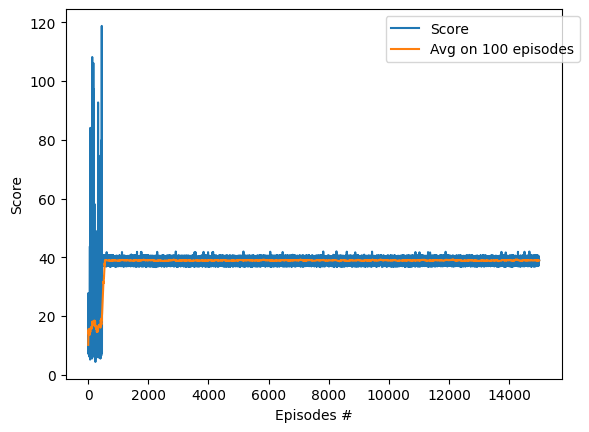

In [ ]:
import matplotlib.pyplot as plt


# Plot results
print('length of scores: ', len(scores), ', length of avg_scores: ', len(avg_scores))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(scores)+1), scores, label="Episode Reward")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="100-Episode Average")
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.title('Training Performance')
plt.show()

The above result is for 15000 episodes.

In the above code, I have Implemented-Polyak Averaging,Dual Critic Networks,Prioritized Replay Buffer and n-steps action.
I have discarded the target policy smoothening of TD3.


In [ ]:
def evaluate_agent(env, agent, n_episodes):
    recent_scores = deque(maxlen=100)
    all_scores = []
    
    for episode in range(1, n_episodes+1):
        state = env.reset()[0]
        episode_reward = 0
        
        start_time = time.time()
        
        while True:
            action = agent.get_action(np.array(state))
            
            # Optional delay for visualization
            time.sleep(0.01)
            
            result = env.step(action)
            next_state, reward, terminated, truncated = result[0], result[1], result[2], result[3]
            done = terminated or truncated
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        elapsed_time = int(time.time() - start_time)
        
        recent_scores.append(episode_reward)
        all_scores.append(episode_reward)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'.format(
               episode, np.mean(recent_scores), episode_reward, 
               elapsed_time//3600, elapsed_time%3600//60, elapsed_time%60))

# Evaluate the trained agent
evaluate_agent(env=env, agent=agent, n_episodes=7)


In [ ]:
env.close()